In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import col

In [2]:
# Initialisation de la session Spark avec Hive
spark = SparkSession.builder \
    .appName("Analyse Immatriculations") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

# Utilisation de la base Hive
spark.sql("USE concessionnaire")

# Chargement des données d'immatriculations
immatriculation_df = spark.sql("SELECT * FROM client_immatriculation_categorie")

# Afficher un aperçu des données
immatriculation_df.show(10)


+---------------+---+-----+----+-------------------+---------------+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+------+----------------+
|immatriculation|age| sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture| marque|puissance|   longueur|nbplaces|nbportes|couleur|occasion|   prix|modele|       categorie|
+---------------+---+-----+----+-------------------+---------------+---------------+-------+---------+-----------+--------+--------+-------+--------+-------+------+----------------+
|        0 OG 13| 56|Homme| 528|        Célibataire|              0|          false|   Audi|       75|     courte|       5|       5|  blanc|    true|12817.0|    A2|        citadine|
|        0 OZ 65| 32|Homme| 563|          En Couple|              2|          false|   Ford|      125|     longue|       5|       5|  blanc|   false|23900.0|Mondeo|       familiale|
|        1 PD 24| 28|Homme| 230|          En Couple|              2|          false|Renaul

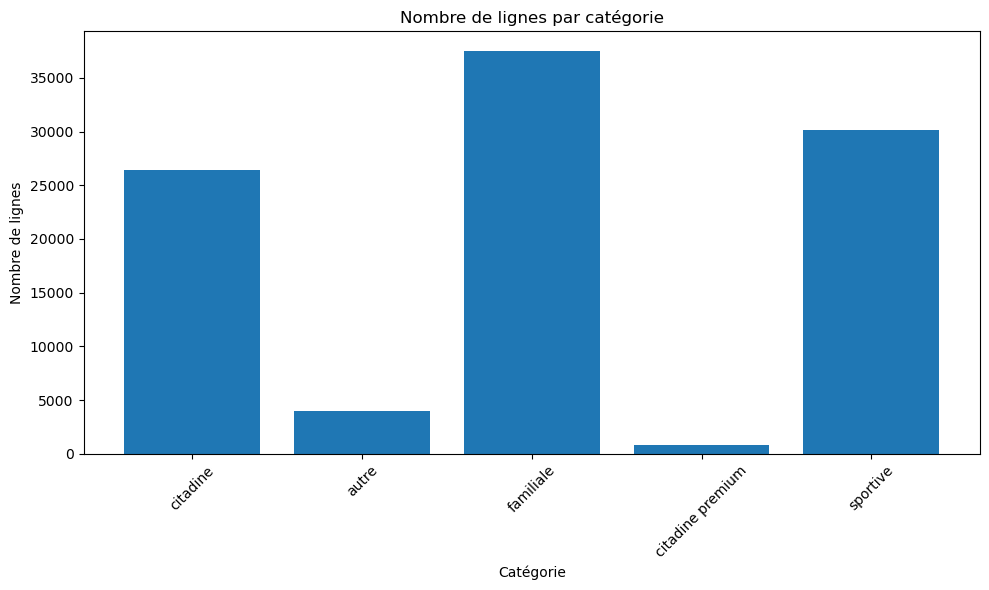

In [6]:
import matplotlib.pyplot as plt

# Groupement des données par catégorie et comptage du nombre de lignes
categorie_counts = immatriculation_df.groupBy("categorie").count().toPandas()

# Création d'un graphique en barres
plt.figure(figsize=(10, 6))
plt.bar(categorie_counts['categorie'], categorie_counts['count'])
plt.xlabel('Catégorie')
plt.ylabel('Nombre de lignes')
plt.title('Nombre de lignes par catégorie')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
